In [ ]:
import numpy as np
import os
import pandas as pd
import json
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# our utils functions
from utils import *

# our classes
from classes.PreprocessData import *
from classes.EvaluateModel import *

In [3]:
# read test data
data_list = []

# read data
# train_df = pd.read_csv('data/mix/data41mix_train.csv')
test_df = pd.read_csv('data/mix/data41mix_test.csv')

In [4]:
# initialize preprocess class
preprocess = PreprocessData()

# # # split data, normalize, shuffle
# X_train, y_train = preprocess.preprocess_data(train_df, normalize=False)
X_test, y_test = preprocess.preprocess_data(test_df, normalize=False)

In [5]:
# # get sclaer values of train data and save it

# scaler = preprocessing.StandardScaler().fit(X_train)

# scaler_values = np.vstack((scaler.mean_,scaler.var_))

# data_header='0'
# for i in range(2807): data_header += ',' + str(i+1)
# np.savetxt('scaler_values.cvs', scaler_values, delimiter=',',header=data_header)

mean_var = pd.read_csv('scaler_values.csv')
mean = mean_var.values[0,:]
var =  mean_var.values[1,:]

In [6]:
import math
for idx_non in range(2808):
    X_test[:,idx_non]=(X_test[:,idx_non]-mean[idx_non])/(math.sqrt(var[idx_non]))

In [7]:
data_list.append([X_test,y_test])

In [8]:
print('Size of testing matrix:', data_list[0][0].shape)

Size of testing matrix: (4593, 2808)


In [11]:
unique_words = set(data_list[0][1])

# class size
class_size=len(unique_words)
print(unique_words)

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0}


In [12]:
model_grid = [
    {      
            'model_name': "NNs",
            'api_name': 'hmmlearn',
            'model_type': "onevsall", 
            'model_path': "models/NNs/mix"
            'scaler_path': "scaler_values.csv",
            'dict_path': 'dict41.txt',
            'class_size': 41
    }

]

In [13]:
eval_model_dir = dict()

for model in model_grid:
    print(model['model_name'])
    
    # initialize evaluate model
    evaluate = EvaluateModel(model['model_name'], model['api_name'], model['model_type'], model['model_path'], model['scaler_path'], model['dict_path'], class_size=41)
    # get model
    evaluate.models = evaluate.get_models()
    # append model to dict
    eval_model_dir[model['model_name']] = evaluate
    
    del evaluate

NNs


In [14]:
import json

class_size=41

# get label dict
with open('dict41.txt', encoding='utf-8') as data_file:
    data = json.loads(data_file.read())
    
# get labels by order
label = [data[str(i)] for i in range(class_size)]

NNs


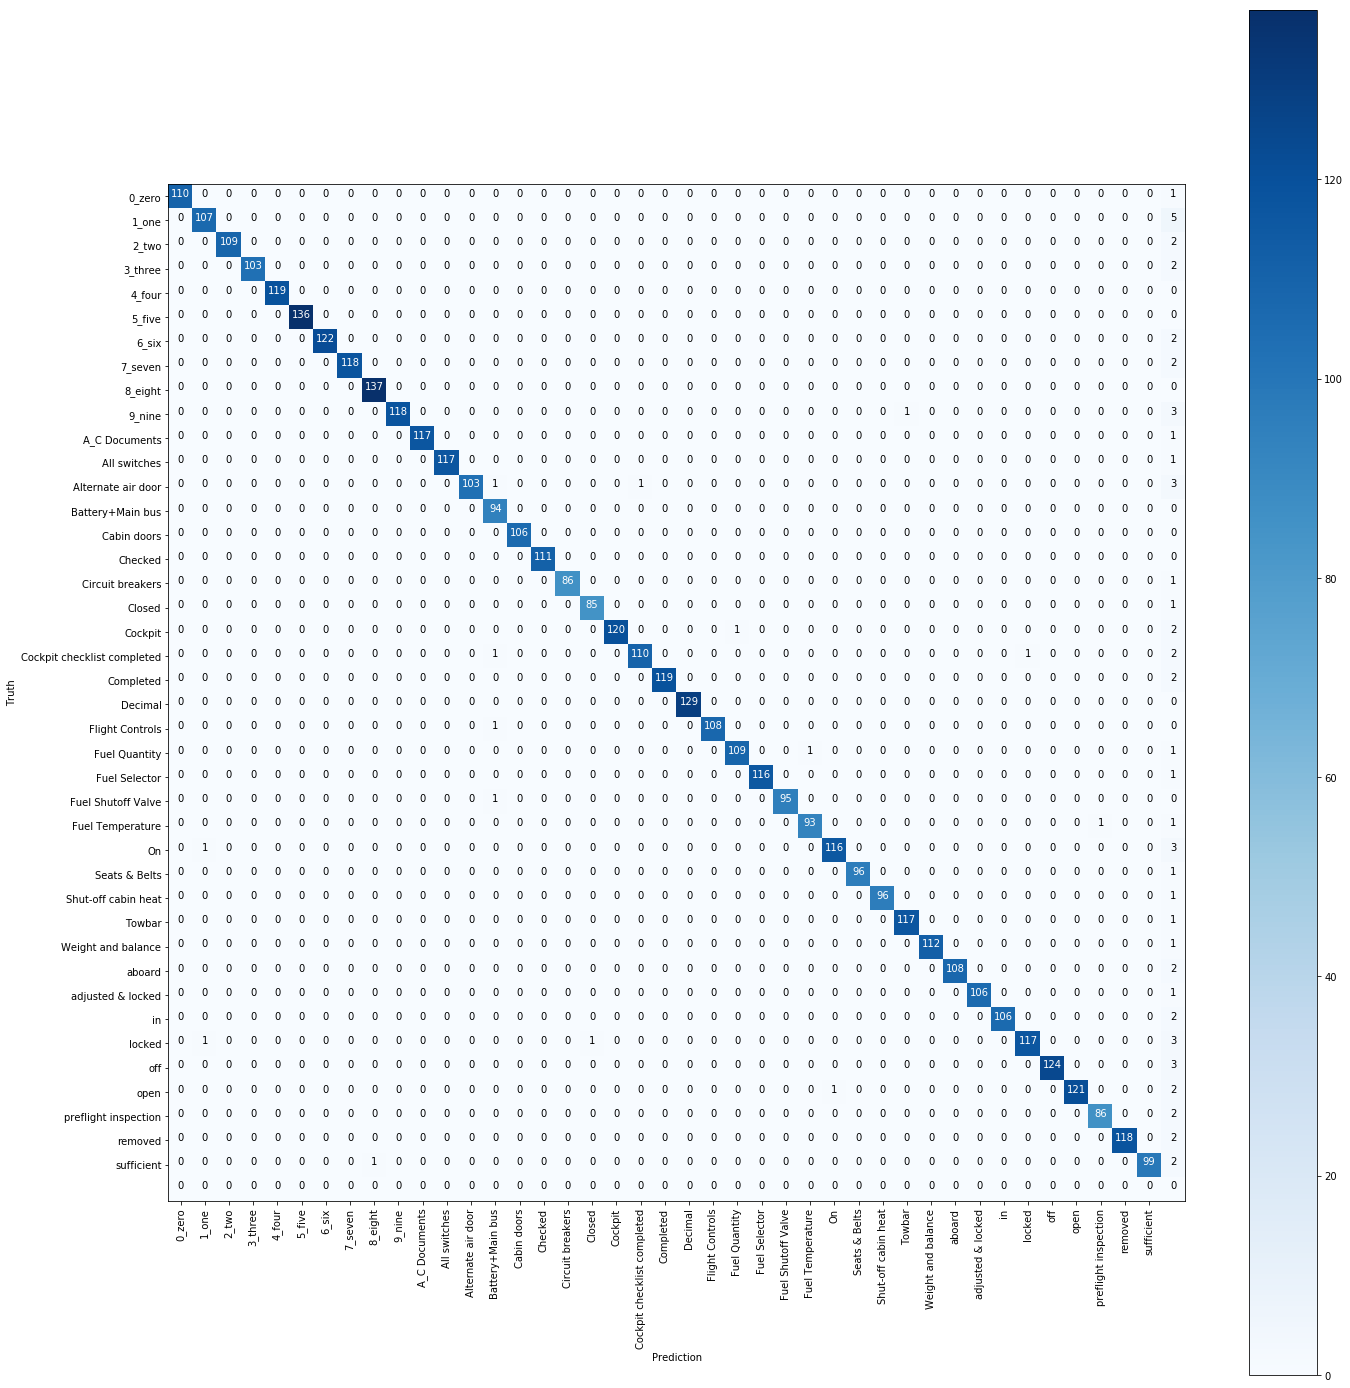

In [15]:
result_l = []
rejection_l =[]
total_rejection_l =[]

for i in range(len(data_list)):
    
    model_g = model_grid[0]
    
    X_test= data_list[i][0]
    y_test= data_list[i][1]
    
    # get model
    model = eval_model_dir[model_g['model_name']]
    # get prediction results
    result, predicted_labels = model.calculate_res(model.models, h1=0.9, h2=0.5, X_test=X_test, target=y_test)
    # calculate confussion matrics
    conf_matric = model.calculate_conf_mat(target=y_test, predicted_labels=predicted_labels)
    # get rejection values
    rejection, total_rejection = model.get_rejection_ratio(conf_matric)
    
    result_l.append(result)
    rejection_l.append(rejection)
    total_rejection_l.append(total_rejection)
    
    print(model_g['model_name'])
    # plot conffusion matrics
    plot_confusion_matrix(conf_matric, label, 'Prediction', 'Truth', normalize=False)

In [18]:
header = '{:<{key_width}}{:<{key_width2}}'.format(
    "Target Labels",
    model_grid[0]['model_name'],
    model_grid[0]['model_name'],
    key_width=27,
    key_width2=15
)

In [19]:
for i in range(len(result_l)):
    print("Model: " + model_grid[0]['model_name'])
    print("Accuracy: %.4f" % (np.mean(result_l[i])*100))
    print("Total rejection: %.4f" %(total_rejection_l[i]*100))
    print("Total Error: %.4f\n" %((100-np.mean(result_l[i])*100)-total_rejection_l[i]*100))


print(header)
print('-'*len(header))
for i in range(class_size):
    print('{label1:<{width}} : {ratio1}'.format(label1=str(data[str(i)]), ratio1=("%.4f" %(rejection_l[0][i]*100)), width=26))

Model: NNs
Accuracy: 98.3889
Total rejection: 1.3013
Total Error: 0.3099

Target Labels              NNs            
------------------------------------------
0_zero                     : 0.9009
1_one                      : 4.4643
2_two                      : 1.8018
3_three                    : 1.9048
4_four                     : 0.0000
5_five                     : 0.0000
6_six                      : 1.6129
7_seven                    : 1.6667
8_eight                    : 0.0000
9_nine                     : 2.4590
A_C Documents              : 0.8475
All switches               : 0.8475
Alternate air door         : 2.7778
Battery+Main bus           : 0.0000
Cabin doors                : 0.0000
Checked                    : 0.0000
Circuit breakers           : 1.1494
Closed                     : 1.1628
Cockpit                    : 1.6260
Cockpit checklist completed : 1.7544
Completed                  : 1.6529
Decimal                    : 0.0000
Flight Controls            : 0.0000
Fuel Quanti